# Predicting Video Game Success: A Data Analysis Using Steam Data

# Introduction:

Our project aims to address the research question: Can we predict the success of a video game based on data from previous games? To answer this question, we will undertake several key steps, including data acquisition, data cleaning and management, graphical visualization, in-depth analysis, and the development of a machine learning model.

By following this structured approach, we will be able to gain valuable insights into the factors that contribute to a game's success and explore the potential for predictive modeling in the gaming industry. Our project will provide a comprehensive analysis of the data, enabling us to draw meaningful conclusions and make informed assessments regarding the success of video games.


**Importing libraries**

In [88]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import re

# **Data Acquisition**

In this project, we utilize Steam as our primary source for data accumulation.

Steam is a prominent online store and community known for its extensive collection of PC games, making it an ideal platform for obtaining data and developing an effective prediction model.

**Defining the get_data_shop function:**

To gather data from Steam, we begin by examining the structure of the Steam store page.

We discovered that the store page operates using a JSON file, which contains information about various games available on the platform.

The get_data_shop function is designed to extract the necessary data from this JSON file.

In [ ]:
def get_data_shop(url):
    try:
        r = requests.get(url)
        r.raise_for_status()
        data = dict(r.json())
        return data['results_html']
    except requests.exceptions.RequestException as e:
        return None


**Defining the get_data_page function:**

Each game on Steam has its own dedicated page containing additional information and statistics.

To access this data, we utilize the links obtained from the store page.

The get_data_page function is responsible for retrieving the HTML content of each game's page and extracting the desired data.

In [ ]:
def get_data_page(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        return None

For our data scrapping function we defined several lists and variables related to video game tags and retrieving data from the Steam store.

To gather the necessary features for our project, we encountered a diverse range of tags on the game pages. These tags include not only genres but also specific features of the games. In order to organize these tags into specific feature columns in our data file, we created lists to assist us in sorting and categorizing the tags

Additionally, we aimed to determine our definition of success by considering the data of top selling games. To accomplish this, we scraped the names of all the games that were ranked as top sellers and saved them in a list. The index of each game in the list corresponds to its ranking placement.

Since the "Top Ranking" tag or placement is not available on every game page, we had to scrape that data from a separate page on the Steam website. This page contains a list of all the top selling games, which allowed us to retrieve the necessary information for our analysis.

In [ ]:
non_genre_tags = ['Singleplayer', 'Multiplayer', 'Online Pvp', 'Co-op', 'Online Co-Op', 'VR', 'Free to Play','Local Multiplayer', 'Local Co-Op', 'Massively Multiplayer']
num_player_tags = ['Singleplayer', 'Multiplayer', 'Online Pvp', 'Co-op', 'Online Co-Op', 'Local Multiplayer', 'Local Co-Op', 'Massively Multiplayer']
num_feature_tags = ['Single-player', 'Multi-player', 'PvP', 'Online PvP', 'Lan PvP', 'Shared/Split Screen PvP', 'Co-op',
                     'Online Co-op', 'Lan Co-op', 'Shared/Split Screen Co-op', 'Shared/Split Screen', 'Cross-Platform Multiplayer']
vr_tags = ['VR Only', 'VR Supported']

top_seller_url = 'https://store.steampowered.com/search/?filter=topsellers&os=win'
top_seller_data = get_data_page(top_seller_url)
top_titles = []

if top_seller_data:
    top_seller_soup = BeautifulSoup(top_seller_data, 'html.parser')
    top_seller_titles = top_seller_soup.find_all('span', {'class': 'title'})
    for top_seller in top_seller_titles:
        top_title = top_seller.text.strip()
        top_titles.append(top_title)
        


**Defining the parse function:**

The parse function performs the parsing and extraction of data from the HTML content in every game page.

Here's an overview of how the function works:

It takes the HTML data as input and returns a list of dictionaries, where each dictionary represents the extracted data for a game.

It initializes an empty list called data_file to store the extracted data.

The HTML content is parsed using the BeautifulSoup library, creating a soup object.

The function finds all game elements ("a" tags) within the HTML using the find_all method and limits the number of games to 50 (since every store page has a limit of 50 games).

For each game element, the function extracts various data points such as the game's URL, title, price, genres, features, number of players, VR support, cross-platform support, developers, publishers, release date, review score, number of reviews, languages, and selling rank.

The extracted data is stored in a dictionary called our_data.

The our_data dictionary is appended to the data_file list.

Once all game elements have been processed, the function returns the data_file list containing the extracted data.

In [ ]:
def parse(data):
    global top_titles
    data_file =  []
    soup = BeautifulSoup(data, 'html.parser')
    games = soup.find_all('a', limit= 50)

    for game in games:
        
        new_url = game['href']

        new_data = get_data_page(new_url)
        if new_data:
             new_game = BeautifulSoup(new_data, 'html.parser')
             title = new_game.find('div', {'class': 'apphub_AppName'})
             if title:
                title = title.text.strip()
             else:
                title = '-'
        else:
            break   

        discounted_price = new_game.find('div', {'class': 'discount_original_price'})
        if discounted_price:
            original_price =  discounted_price.text.strip()      

        else:
            original_price = new_game.find('div', {'class':'game_purchase_price'})
            if original_price:
                original_price =  original_price.text.strip()  
            else:
                original_price = '-'

        possible_tags = new_game.find_all('a', {'class': 'app_tag'})
        genres = []
        features = []
        num_of_players = []
        VR_Support = False
        cross_platform = False
        
        if possible_tags:
            for tag in possible_tags:
                tag = tag.text.strip()
                if (tag in non_genre_tags):
                    if (tag in num_player_tags):
                        num_of_players.append(tag)
                    
                    elif (tag == 'VR'):
                        VR_Support = True

                    continue

                else:
                  genres.append(tag)
        
        possible_features = new_game.find_all('div', {'class': 'label'})
        if possible_features:
            for feature in possible_features:
                feature = feature.text.strip()
                if feature == ('Cross-Platform Multiplayer'):
                    cross_platform = True

                elif feature in num_feature_tags and feature not in num_of_players:
                    num_of_players.append(feature)

                elif feature in vr_tags:
                  VR_Support = True

                else:
                    features.append(feature)


        devs = []
        pubs = []
        total_dev_followers = 0
        total_pub_followers = 0
        total_followers = 0

        all_elements = new_game.find_all('div', {'class': 'dev_row'})
        if all_elements:
            developer_elements = all_elements[0]
            temp_urls = developer_elements.find_all('a')
            if(temp_urls):
                for temp_url in temp_urls:
                    dev_name = temp_url.text.strip()
                    dev_url = temp_url['href']
                    dev_data = get_data_page(dev_url)
                    if (dev_data is not None):
                        new_dev = BeautifulSoup(dev_data, 'html.parser')
                        if(new_dev):
                            dev_followers = new_dev.find('div', {'class':'num_followers'})
                            if dev_followers:
                                dev_followers = dev_followers.text.strip()
                                total_dev_followers += int (dev_followers.replace(',', ''))

                            else:   
                                 dev_followers = 0
                        if(dev_name):
                            devs.append(dev_name)
                        else:
                            devs.append('-')
                    else:
                            devs.append('-')    

            else:
                devs.append('-')
                                 
            if (len(all_elements) > 1):
                publisher_elements =  all_elements[1] 
                temp_urls= publisher_elements.find_all('a')
                if (temp_urls):
                    total_followers = total_dev_followers
                    for temp_url in temp_urls:
                        pub_name = temp_url.text.strip()
                        pub_url = temp_url['href']
                        pub_data = get_data_page(pub_url)
                        if (pub_data is not None):
                            new_pub = BeautifulSoup(pub_data, 'html.parser')
                            if(new_pub):
                                pub_followers = new_pub.find('div', {'class':'num_followers'})
                                if pub_followers:
                                    pub_followers = pub_followers.text.strip() 
                                    total_pub_followers += int (pub_followers.replace(',', ''))
                                    if pub_name not in devs:
                                        total_followers += total_pub_followers
                                    else:
                                        pub_followers = 0
                            if (pub_name):
                                pubs.append(pub_name)
                            else:
                                pubs.append('-')
                        else:
                            pubs.append('-')
                else:
                    pubs.append('-')
            else:
                pubs.append('-')
        

        release_date = new_game.find('div', {'class':'date'})
        if release_date:
            release_date = release_date.text.strip()
        else:
            release_date = '-'

        reviews = new_game.find_all('span', {'class': 'nonresponsive_hidden responsive_reviewdesc'})
        if reviews:
            for i, review in enumerate(reviews):
                if i == 1:  
                    review_text = review.text.strip()
                    review_score = re.search("\d+", review_text)
                    if review_score:
                        review_score = review_score.group(0) + '%'
                    else:
                        review_score = '-'
                    review_numbers = new_game.find('div', {'class':'user_reviews'})
                    review_numbers = review_numbers.find_all('span', {'class': 'responsive_hidden'})
                    if review_numbers:
                        review_numbers = int (review_numbers[1].text.strip().replace(',', '').replace('-','').replace('(','').replace(')',''))
                    else:
                        review_numbers = '-'
                    break
                else:
                    review_numbers = '-'
                    review_score = '-'
        else:
            review_numbers = '-'
            review_score = '-'
        

        possible_languages = new_game.find_all('td', {'class': 'ellipsis'})
        if possible_languages:
            languages = [language.text.strip() for language in possible_languages]
        else:
            languages = '-'

        if title in top_titles:
            title_index = top_titles.index(title) 
            top_seller = title_index + 1
        else:
            top_seller = '-'

            
        our_data = {
            'Title': title,
            'Price': original_price,
            'Geners': genres,
            'Num of Players': num_of_players,
            'Features': features,
            'VR support': VR_Support,
            'Cross Platform': cross_platform,
            'Developers': devs,
            'Developers Followers': total_dev_followers,
            'Publishers': pubs,
            'Publishers Followers': total_pub_followers,
            'Total Followers': total_followers,
            'Release Date': release_date,
            'Review Score': review_score,
            'Number of Reviews': review_numbers,
            'Languages': languages,
            'Selling Rank': top_seller
            }

        data_file.append(our_data)
            
                            
    return data_file

**Defining the output function:**

The output function is responsible for saving the extracted data into a CSV file. It takes two parameters: ourdata, which is the data to be saved, and filepath, which specifies the path and filename of the CSV file. If the file does not exist, it creates a new file. If the file already exists, it appends the new data to the existing file.

In [89]:
def output(ourdata, filepath):
    if ourdata:
        df_new = pd.DataFrame(ourdata)
        if not os.path.isfile(filepath):
            df_new.to_csv(filepath, index=False)
        else:
            df = pd.read_csv(filepath)
            df = pd.concat([df, df_new], ignore_index=True)
            df.to_csv(filepath, index=False)
        print('Done!')
    else:
        print('No data to save.')


After defining the output and parse functions, we implement the code which scrape data from the Steam store in multiple iterations (since each store page contains only 50 games) and saves the extracted data into a CSV file. 

The progress is printed after each iteration, and the data is saved only if there is data available.

In [ ]:
filepath = 'gamedata.csv'
ourdata = []
for x in range(0, 55000, 50):
   data = get_data_shop(f'https://store.steampowered.com/search/results/?query&start={x}&count=50&dynamic_data=&sort_by=_ASC&snr=1_7_7_230_7&category1=998&supportedlang=english&infinite=1')
   if data is None:
        continue
   else:
        ourdata.extend(parse(data))
        print('Results Scraped:', x+50)

   if len(ourdata) > 0:
        output(ourdata, filepath)
        ourdata = []

**Defining the review_parse function:**

After we scraped the data and reviewed the CSV file, we noticed that some game pages had faulty or missing review scores and numbers.

Since these features are crucial in defining a game's success, we created another parsing function called 'review_parse'.

This function, similar to the initial parse, scrapes specific data such as title, review score, and numbers from the store page itself, rather than the individual game page. The extracted information is then saved in a dictionary."

In [ ]:
def review_parse(data):
    data_file = []
    soup = BeautifulSoup(data, 'html.parser')
    games = soup.find_all('div', {'class': 'responsive_search_name_combined'}, limit=50)

    for game in games:
        title = game.find('span', {'class': 'title'})
        if title:
            title = title.text.strip()
        else:
            title = '-'

        print(title)

        class_names = ['positive', 'mixed', 'negative']
        percentage = "-"
        num_reviews = "-"
        found_match = False

        for class_name in class_names:
            reviews = game.find_all('span', {'class': 'search_review_summary ' + class_name})
            if reviews:
                tooltip_html = reviews[0]['data-tooltip-html']
                review_score_match = re.search(r'\b(\d+)%', tooltip_html)
                num_reviews_match = re.search(r'(\d+(?:,\d+)*)\s+user reviews', tooltip_html)

                if review_score_match:
                    percentage = review_score_match.group(1) + '%'
                    found_match = True

                if num_reviews_match:
                    num_reviews = num_reviews_match.group(1).replace(',', '')
                    found_match = True

                if found_match:
                    break


        our_data = {
            'Title': title,
            'Review Score': percentage,
            'Number of Reviews': num_reviews,
        }

        data_file.append(our_data)

    return data_file


Like before, we run through a code which scrape data from the Steam store in multiple iterations and saves the extracted data into a CSV file. 

In [ ]:
filepath = 'review_gamedata.csv'
ourdata = []
for x in range(0, 55000, 50):
   data = get_data_shop(f'https://store.steampowered.com/search/results/?query&start={x}&count=50&dynamic_data=&sort_by=_ASC&snr=1_7_7_230_7&category1=998&supportedlang=english&infinite=1')
   if data is None:
        continue
   else:
        ourdata.extend(review_parse(data))
        print('Results Scraped:', x+50)

   if len(ourdata) > 0:
        output(ourdata, filepath)
        ourdata = []

Now that we have two CSV files, one containing all the data but with faulty review scores and review numbers, and the second containing the correct data for those fields, we will implement code to combine both CSV files into a single, comprehensive CSV file.

In [ ]:
df_base = pd.read_csv('filtered_gamedata.csv')
df_new = pd.read_csv('review_gamedata.csv')

for index, row in df_base.iterrows():
    title = row['Title']
    
    matching_row = df_new[df_new['Title'] == title]

    if not matching_row.empty:
        review_score = matching_row.iloc[0]['Review Score']
        num_reviews = matching_row.iloc[0]['Number of Reviews']

        df_base.at[index, 'Review Score'] = review_score
        df_base.at[index, 'Number of Reviews'] = num_reviews

df_base.to_csv('done_gamedata.csv', index=False)


# PROCESSING DATA

In order to start and work on our data we first gonna load the correct csv file.

In [111]:
df = pd.read_csv('done_gamedata.csv')

After reviewing the data, we observed that there are 454 different genre tags. To facilitate appropriate visualization and for future machine learning tasks, we decided to map these diverse tags into similar categories.

To accomplish this, we carefully examined each unique genre tag and assigned them to specific categories based on their similarities. This categorization was done by leveraging our knowledge of video games and conducting thorough online research on each genre. As a result, we successfully sorted the 454 different tags into 22 distinct categories (technically 21 categories, as one category was designated for deletion. This category included irrelevant genre tags that would be sorted into separate feature columns in the data file. For instance, the tag 'controller' is irrelevant since we already have a column dedicated to features, including controller support).

Using the newly created CSV file containing the sorted genre tags, we constructed a mapping dictionary. We then implemented this mapping dictionary on our original data file, ensuring that we only have the new genre categories in our dataset.

In [112]:
df_genre = pd.read_csv('Genresdata.csv')

mapping_dict = {}
categories = df_genre.columns.tolist()
for category in categories:
    sub_genres = df_genre[category].dropna().tolist()
    for sub_genre in sub_genres:
        mapping_dict[sub_genre.strip(" ").strip("'")] = category.strip(" ").strip("'")


updated_df = df.copy()

for index, row in df.iterrows():
    genre_list = []
    row_list = row['Genres'].split(',') 
    mapped_genres = set() 

    for genre in row_list:
        genre = genre.strip("[]").strip("'").strip(" ").strip("'")
        if genre in mapping_dict:
            mapped_genre = mapping_dict[genre]
            if mapped_genre and mapped_genre != 'Delete' and mapped_genre not in mapped_genres:
                genre_list.append(mapped_genre)
                mapped_genres.add(mapped_genre)
        else:
            genre_list.append(genre)
    
    genre_list = list(set(genre_list))
    genre_list = [genre for genre in genre_list if genre]
    updated_df.at[index, 'Genres'] = genre_list

updated_df.to_csv('updated_gamedata.csv', index=False)    

After reviewing the genres we saw we still have a very diverse data. 

recognizing the diverse range of price data, we decided to establish fixed price ranges to better organize this information. 

Additionally, we categorized the release dates of the games into seasons and years, reducing the granularity of the data entries.

Once these modifications were implemented, we saved the updated data file, marking the completion of the data processing stage.

These changes not only improve the visual representation of the data but also lay the foundation for more streamlined analysis and modeling in the future

In [113]:
df = pd.read_csv('updated_gamedata.csv')

df['Price'] = df['Price'].astype(str)

df['Price'] = df['Price'].str.replace('₪', '')

df['Price'] = df['Price'].str.lower().replace(['free', 'free to play'], '0')

df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df['Price'] = np.round(df['Price'], decimals=0)

df['Release Season'] = df['Release Date'].str.split(',').str[0].str.split().str[1].map({
    'Mar': '1', 'Apr': '1', 'May': '1',
    'Jun': '2', 'Jul': '2', 'Aug': '2',
    'Sep': '3', 'Oct': '3', 'Nov': '3',
    'Dec': '4', 'Jan': '4', 'Feb': '4'
})
df['Release Year'] = df['Release Date'].str.split().str[-1]

df = df.drop('Release Date', axis=1)

df['Number of Languages'] = df['Languages'].apply(lambda x: len(ast.literal_eval(x)))

df['Review Score'] = pd.to_numeric(df['Review Score'].str.rstrip('%'), errors='coerce')

df['Selling Rank'] = pd.to_numeric(df['Selling Rank'], errors='coerce')

for index, row in df.iterrows():
    selling_rank = row['Selling Rank']
    developers = row['Developers']
    publishers = row['Publishers']
    
    if pd.isna(selling_rank):
        df.at[index, 'Developers'] = 'Small developer'
        
        df.at[index, 'Publishers'] = 'Small publisher'

df.to_csv('modified_gamedata.csv', index=False)


# Exploratory Data Analysis and Visualization

After successfully completing the data processing stage, we proceed to load our finalized dataset. 

In [114]:
# Read the CSV file
df = pd.read_csv('modified_gamedata.csv')

**The first graph we wanted to showcase is the Distribution of Review Scores:**

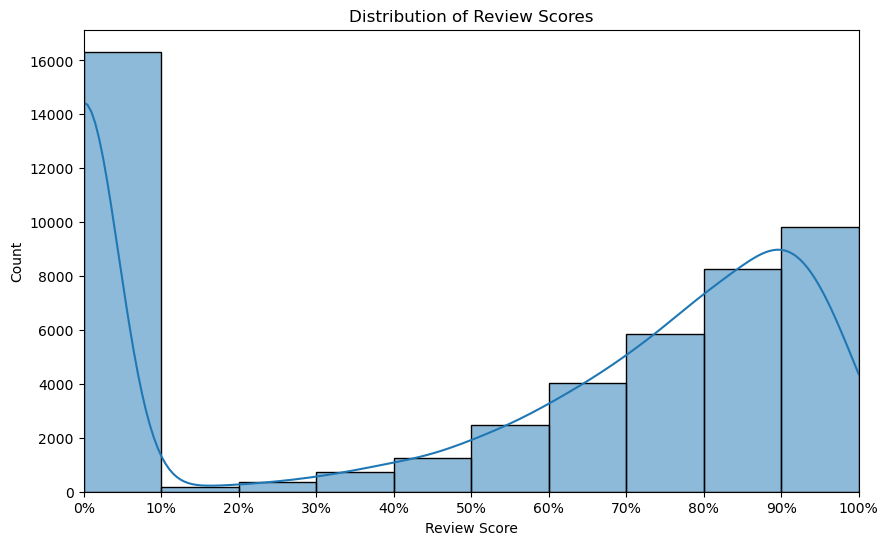

In [115]:
plt.figure(figsize=(10, 6))
bins = list(range(0, 110, 10)) 
sns.histplot(df['Review Score'], bins=bins, kde=True)
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.title('Distribution of Review Scores')
plt.xticks(bins, [f"{x}%" for x in bins])  
plt.xlim(0, 100)
plt.show()

The  graph provides a visual representation of how review scores are distributed across the dataset, showing the concentration of scores in different intervals. The histogram bars represent the count of games falling within each interval, while the KDE plot provides a smooth estimate of the underlying distribution of scores. we can see that there are a big number of games with review scores of 0% (this includes games that got a very low number of reviews and for our research considered as unsuccessful games)

**The next Graph showcased will examine the raltionship between Review Scores, Number of Reviews and Selling Rank:**

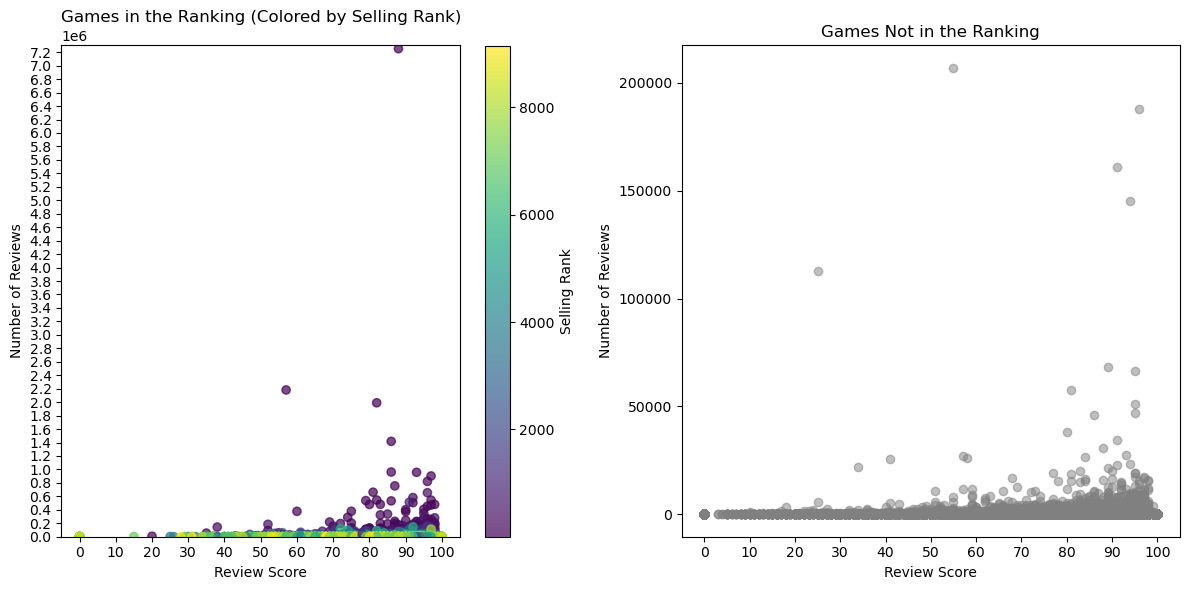

Average Score for Top 10% of Top Ranking Games: 82.18386377457936
Average Number of Reviews for Top 10% of Top Ranking Games: 4149.386580174336
Average Score for Remaining Games: 48.443438506407226
Average Number of Reviews for Remaining Games: 1418.274350832151
Average Score for Unranked Games: 47.79842350083637
Average Number of Reviews for Unranked Games: 183.85307394422676


In [116]:

    score_intervals = np.arange(0, 101, 10)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    sc1 = ax1.scatter(df['Review Score'], df['Number of Reviews'], c=df['Selling Rank'], cmap='viridis', alpha=0.7)
    ax1.set_xlabel('Review Score')
    ax1.set_ylabel('Number of Reviews')
    ax1.set_title('Games in the Ranking (Colored by Selling Rank)')
    plt.colorbar(sc1, ax=ax1, label='Selling Rank')

    max_num_reviews = df['Number of Reviews'].max()
    max_y_limit = (max_num_reviews // 100000 + 1) * 100000
    ax1.set_ylim(0, max_y_limit)
    ax1.set_yticks(np.arange(0, max_y_limit + 100000, 200000))

    sc2 = ax2.scatter(df[df['Selling Rank'].isnull()]['Review Score'], df[df['Selling Rank'].isnull()]['Number of Reviews'],
                c='gray', marker='o', alpha=0.5)
    ax2.set_xlabel('Review Score')
    ax2.set_ylabel('Number of Reviews')
    ax2.set_title('Games Not in the Ranking')

    ax1.set_xticks(score_intervals)
    ax2.set_xticks(score_intervals)

    plt.tight_layout()
    plt.show()


    df['Selling Rank'] = pd.to_numeric(df['Selling Rank'], errors='coerce')
    df['Review Score'] = pd.to_numeric(df['Review Score'], errors='coerce')

    df_sorted = df.sort_values('Selling Rank', ascending=False)

    top_10_threshold = int(len(df_sorted) * 0.1)

    top_10_percent = df_sorted.head(top_10_threshold)

    remaining_games = df_sorted.tail(len(df_sorted) - top_10_threshold)

    avg_top_10_score = top_10_percent['Review Score'].mean()
    avg_top_10_reviews = top_10_percent['Number of Reviews'].mean()

    avg_remaining_score = remaining_games['Review Score'].mean()
    avg_remaining_reviews = remaining_games['Number of Reviews'].mean()

    print("Average Score for Top 10% of Top Ranking Games:", avg_top_10_score)
    print("Average Number of Reviews for Top 10% of Top Ranking Games:", avg_top_10_reviews)
    print("Average Score for Remaining Games:", avg_remaining_score)
    print("Average Number of Reviews for Remaining Games:", avg_remaining_reviews)

    unranked_games = df_sorted[df_sorted['Selling Rank'].isnull()]

    if len(unranked_games) > 0:
        unranked_score_copy = unranked_games['Review Score'].copy()

        unranked_score_copy = pd.to_numeric(unranked_score_copy, errors='coerce')

        unranked_score_copy = unranked_score_copy.fillna(1)

        avg_unranked_score = unranked_score_copy.mean()
        avg_unranked_reviews = unranked_games['Number of Reviews'].mean()
        print("Average Score for Unranked Games:", avg_unranked_score)
        print("Average Number of Reviews for Unranked Games:", avg_unranked_reviews)

The scatter plots provide insightful visualizations of the relationship between review scores, number of reviews, and selling rank for different groups of games. The left scatter plot represents games in the top selling ranking, with each data point color-coded based on selling rank. The x-axis represents the review score, and the y-axis represents the number of reviews. The right scatter plot showcases games not in the ranking, represented by gray markers. This comparison allows for a clear distinction between the review scores and number of reviews for ranked and unranked games.

The code also calculates and prints average scores and numbers of reviews for different groups of games, including the top 10% of top ranking games, remaining games, and unranked games.

Upon analyzing the calculated average scores and review numbers, we uncover compelling findings. Firstly, both ranked and unranked games exhibit similar average review scores, indicating that review score alone may not strongly influence a game's success. The slight difference of less than 1% suggests that review score is not a significant distinguishing factor between successful and unsuccessful games.

However, a more nuanced insight emerges when examining the top 10% of the top-selling games. In this subset, there is a noticeable increase in review scores, which is also observed among non-ranking games with higher numbers of reviews. This correlation implies that higher review scores are often associated with a larger volume of reviews.

The most notable disparity lies in the number of reviews. Unranked games have an average of 183.85 reviews, whereas top-ranking games have nearly eight times more reviews, and the top 10% of ranking games have almost 23 times more reviews on average. This highlights the critical role of review count in a game's success and its placement within the top-selling rankings.

In summary, the analysis reveals that while review scores alone may not determine a game's success, the number of reviews plays a crucial role. The disparity in review numbers between ranked and unranked games, as well as the top-ranking subset and the remaining games, suggests that a higher volume of reviews is strongly associated with a game's success and its position in the top-selling rankings.

**In this next graph, we will be showcasing the relationship between Selling Rank and the different Genres:**

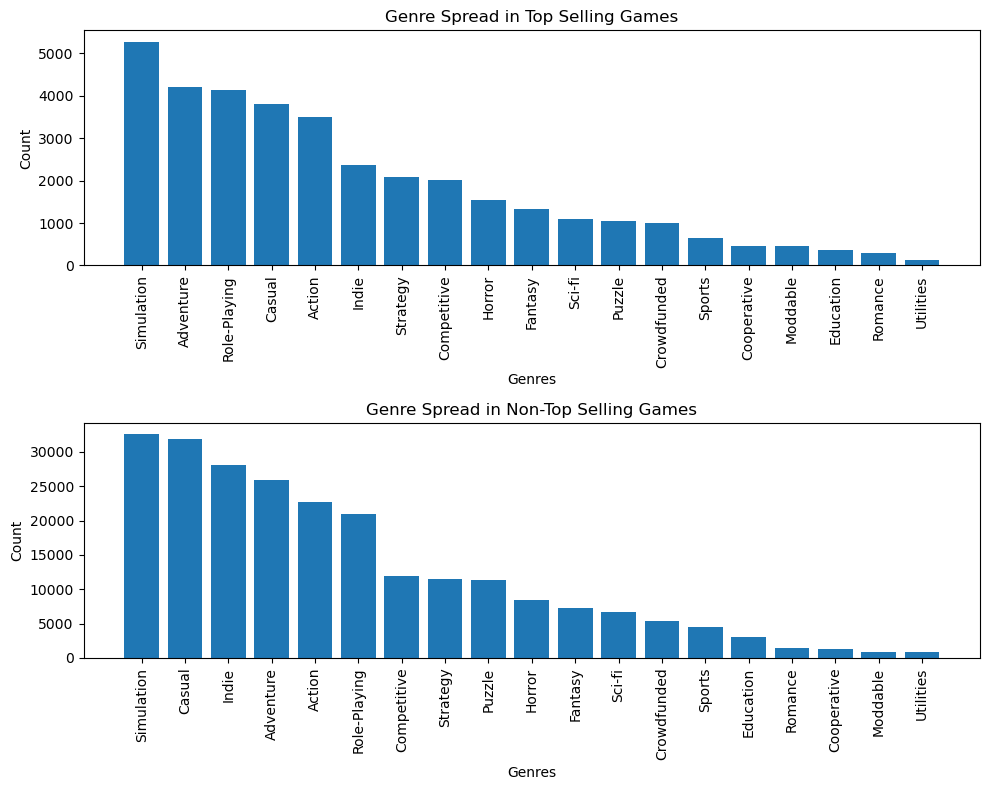

In [117]:
top_selling_games = updated_df[updated_df['Selling Rank']!='-']

non_top_selling_games = updated_df[updated_df['Selling Rank']== '-']

exclude_genres = ['Graphics', 'Music']

top_genre_counts = top_selling_games['Genres'].explode().value_counts().drop(exclude_genres, errors='ignore')

non_top_genre_counts = non_top_selling_games['Genres'].explode().value_counts().drop(exclude_genres, errors='ignore')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].bar(top_genre_counts.index, top_genre_counts.values)
axes[0].set_title('Genre Spread in Top Selling Games')
axes[0].set_xlabel('Genres')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)  

axes[1].bar(non_top_genre_counts.index, non_top_genre_counts.values)
axes[1].set_title('Genre Spread in Non-Top Selling Games')
axes[1].set_xlabel('Genres')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90) 

plt.tight_layout()

plt.show()


The code segment above generates two bar plots representing the genre spread in top selling games and non-top selling games.

The genres 'Graphics' and 'Music' are excluded from the genre counts since they appear across all the other diffrenet genres very evenly and are irrelevant.

we can see that in both graphs there are some strong similarities in the number of review and even placements: Simulation is on the top of both list (since there are a lot of different sub-genres that are under that category and are popular), while the last places are very similar, and a lot of other genres have a similar count ratio in both lists.

but there are differences: we can see that even through the moddable genre takes a small precent of both graphs (meaning there are less moddable games) we can see a strong raise in the counts of that genre on the top seller ranking which means its rarer but is received well. also, Cooperative is another genre that is doing pretty well while taking in consideration the numbers of games that have this genre.

while there are genres who raise on the top selling games there are also games that are more popular on the unranked games - which means they are received worse. like: Education, Puzzle, Indie and Casual and even Adventure (slightly)

We can learn that the most popular game genres might have the most amount of review count but, they are also highly placed in unranked games. which means that the likelihood of those games to be top selling isn't guaranteed to be high, which means a deeper review is needed.

**Now we will be examining the relationship of Review Score, Number of Reviews and Genres:**

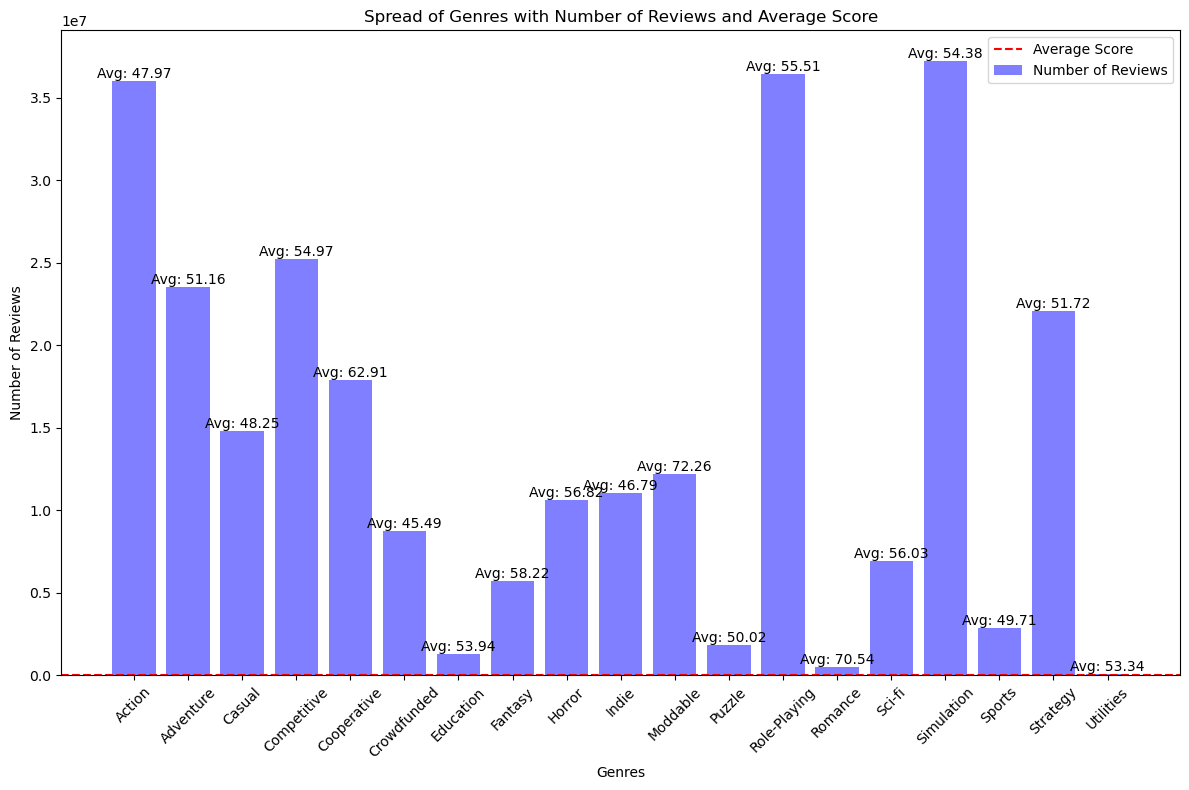

In [118]:
updated_df['Review Score'] = updated_df['Review Score'].str.replace('%', '')
updated_df['Review Score'] = pd.to_numeric(updated_df['Review Score'])

filtered_games = updated_df[updated_df['Review Score'].notnull() & updated_df['Number of Reviews'].notnull()]

exclude_genres = ['Graphics', 'Music']
filtered_games = filtered_games[~filtered_games['Genres'].apply(lambda x: any(genre in exclude_genres for genre in x))]

filtered_games = filtered_games.explode('Genres')

filtered_games['Number of Reviews'] = pd.to_numeric(filtered_games['Number of Reviews'], errors='coerce')

review_numbers = filtered_games.groupby('Genres')['Number of Reviews'].sum()

review_score = filtered_games.groupby('Genres')['Review Score'].mean()

average_score = filtered_games.groupby('Genres')['Review Score'].mean()

fig, ax = plt.subplots(figsize=(12, 8))

x_pos = range(len(review_numbers))

ax.bar(x_pos, review_numbers, color='blue', alpha=0.5, label='Number of Reviews')

ax.axhline(average_score.mean(), color='red', linestyle='--', label='Average Score')

ax.set_xticks(x_pos)
ax.set_xticklabels(review_numbers.index, rotation=45)

ax.set_xlabel('Genres')
ax.set_ylabel('Number of Reviews')
ax.set_title('Spread of Genres with Number of Reviews and Average Score')

for i, genre in enumerate(review_numbers.index):
    avg_score = average_score[genre]
    ax.text(i, review_numbers[genre], f'Avg: {avg_score:.2f}', ha='center', va='bottom')

ax.legend()

plt.tight_layout()
plt.show()


Based on the data, it is evident that the majority of games have a similar average review score, typically around 50%. This finding supports our assumption that the number of reviews plays a crucial role in determining a game's success (unlike Score Review). However, there are notable exceptions to this general pattern.

The genres Cooperative, Moddable, and Romance stand out with significantly higher review scores, despite having a lower number of reviews. Among these genres, the Moddable and Cooperative categories are particularly intriguing and deserving of further analysis. Despite having slightly fewer reviews, they still demonstrate a substantial review count, indicating a notable level of interest and engagement from players.

In contrast, the Romance genre exhibits a very low review count, suggesting that there might be an insufficient number of Romance games available in the dataset to draw a comprehensive assessment. This could imply either a lack of popularity for Romance games in the market or limited representation of such games in the dataset.

**On our latest examination of genres, we will analyze their likelihood of appearing in top-selling games**

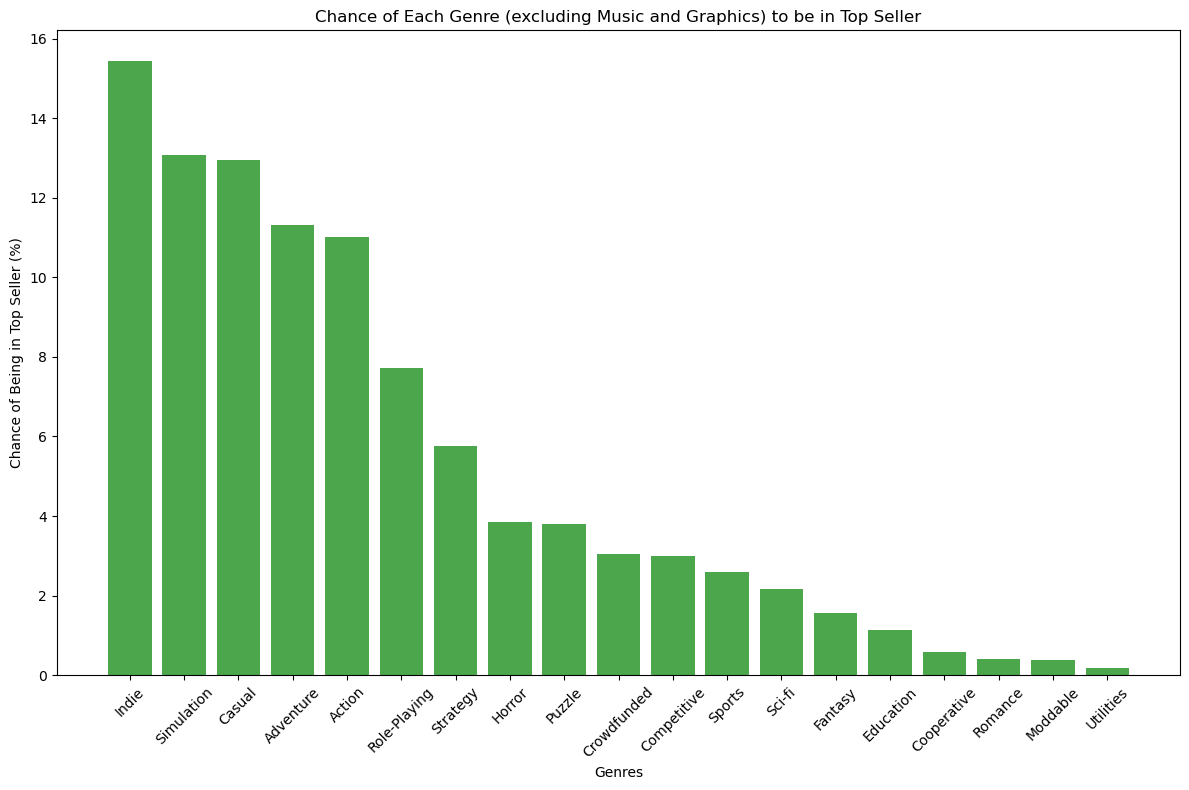

In [108]:
filtered_games = updated_df[updated_df['Selling Rank'].notnull()]

exclude_genres = ['Music', 'Graphics']
filtered_games = filtered_games[~filtered_games['Genres'].apply(lambda x: any(genre in exclude_genres for genre in x))]

filtered_games = filtered_games.explode('Genres')

genre_counts = filtered_games['Genres'].value_counts()

top_seller_counts = filtered_games[filtered_games['Selling Rank'].notnull()]['Genres'].value_counts()

chance_top_seller = (top_seller_counts / len(filtered_games)) * 100

sorted_genres = chance_top_seller.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(sorted_genres.index, sorted_genres, color='green', alpha=0.7)

plt.xticks(rotation=45)

ax.set_xlabel('Genres')
ax.set_ylabel('Chance of Being in Top Seller (%)')
ax.set_title('Chance of Each Genre (excluding Music and Graphics) to be in Top Seller')

plt.tight_layout()
plt.show()

Upon analyzing the genres in relation to their appearance in top-selling games, several interesting observations emerge. The genres that have a higher likelihood of appearing in the top-ranking games include Indie, Simulation, Casual, Adventure, and Action.

It is important to note that these findings challenge the earlier assumption made based solely on review scores. The initial analysis failed to capture the full picture, and a more thorough examination of the data reveals that certain genres have a higher probability of success in terms of sales and popularity.

The genres Moddable and Cooperative seem to have a lower chance of appearing in the top-ranking games. This suggests that games belonging to these genres may face more challenges in achieving commercial success or may have a narrower target audience.

By understanding the genres that have a higher likelihood of appearing in the top-selling games, game developers and industry professionals can make more informed decisions regarding game development, marketing strategies, and resource allocation.

**The upcoming graph illustrates the relationship between the number of languages supported by a game and the number of reviews it receives:**

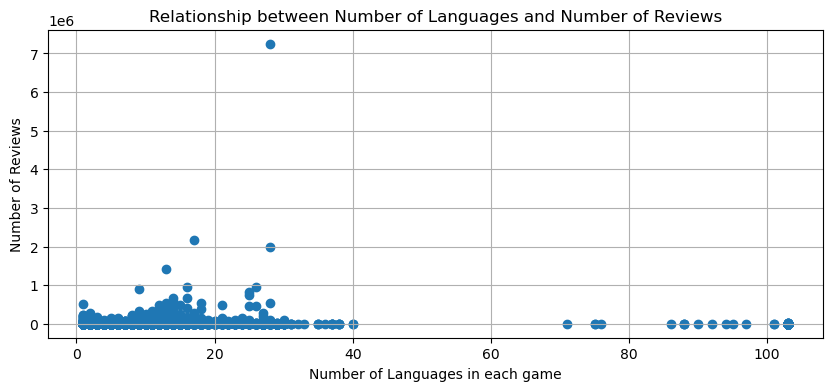

In [100]:

plt.figure(figsize=(10, 4))
plt.scatter(df['Number of Languages'], df['Number of Reviews'])
plt.xlabel('Number of Languages in each game')
plt.ylabel('Number of Reviews')
plt.title('Relationship between Number of Languages and Number of Reviews')
plt.grid(True)


plt.show()

In this graph, we observe a distinct pattern where games with a low or excessive number of supported languages tend to be less successful compared to those with a moderate number of languages, specifically in the range of 10-20 languages. However, it is interesting to note that the highest concentration of reviews occurs in the range of 15-18 languages.

This observation suggests that there may be specific languages that significantly impact the number of reviews a game receives. Therefore, it can be inferred that by localizing a game in these influential languages, developers can enhance the chances of attracting more interaction and ultimately more reviews from players.

**The Next Graph will illustrate the correlation between the price range and the number of reviews.**

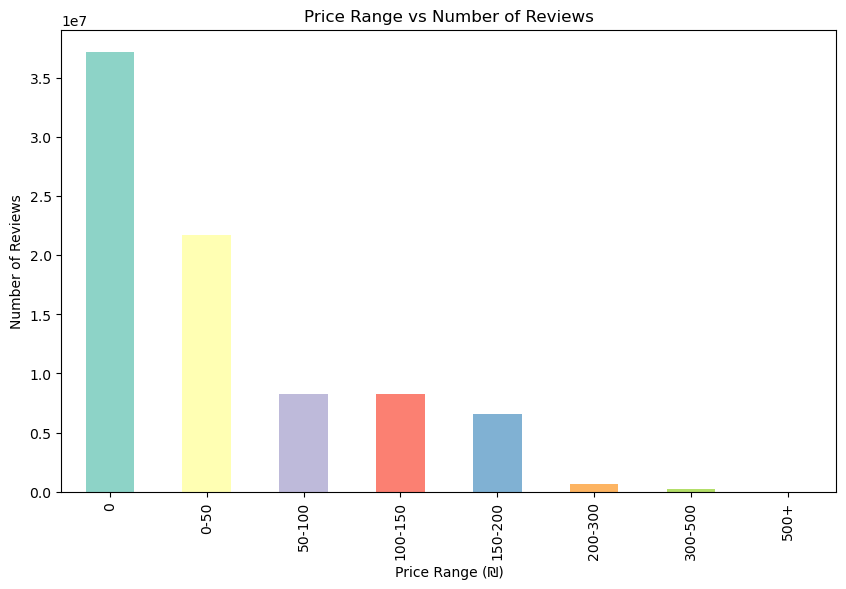

In [101]:
df['Price'] = df['Price'].astype(str)

df['Price'] = df['Price'].str.replace('₪', '')

df['Price'] = df['Price'].str.lower().replace(['free', 'free to play'], '0')

df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

price_ranges = [0, 50, 100, 150, 200, 300, 500,1000, float('inf')]
price_labels = ['0', '0-50', '50-100', '100-150', '150-200', '200-300', '300-500', '500+']

df['Price Range'] = pd.cut(df['Price'], bins=price_ranges, labels=price_labels, right=False)
price_reviews = df.groupby('Price Range')['Number of Reviews'].sum()

plt.figure(figsize=(10, 6))
price_reviews.plot(kind='bar', color=sns.color_palette('Set3', len(price_labels)))
plt.xlabel('Price Range (₪)')
plt.ylabel('Number of Reviews')
plt.title('Price Range vs Number of Reviews')

plt.show()

he data reveals an interesting relationship between the price of games and the number of reviews they receive. Free-to-play games, which require no upfront cost, exhibit the highest level of user engagement and garner the most reviews.

Furthermore, games in the low price range (0₪ - 50₪) also demonstrate a significant number of reviews, indicating that players are more willing to engage with and provide feedback for games that come at a relatively affordable price.

However, as the price range increases, there is a noticeable decline in the number of reviews. Games priced between 50₪ and 100₪ and those priced between 100₪ and 150₪ exhibit similar review counts, while games priced between 150₪ and 200₪ fall slightly behind.

Beyond the 200₪ price range, there is a substantial drop in the number of reviews, suggesting that consumers are less inclined to spend more than 200₪ on a video game.

These findings suggest that players are more inclined to explore and engage with games that are low-cost or free. The prevalence of free-to-play games among the top sellers and their high number of reviews indicate that the model of offering in-game purchases within a free game can be a successful strategy for developers, surpassing the sales potential of higher-priced games without in-game purchases.

**The last graphs will illustrate the correlation between the release year, release season, and the number of reviews.**

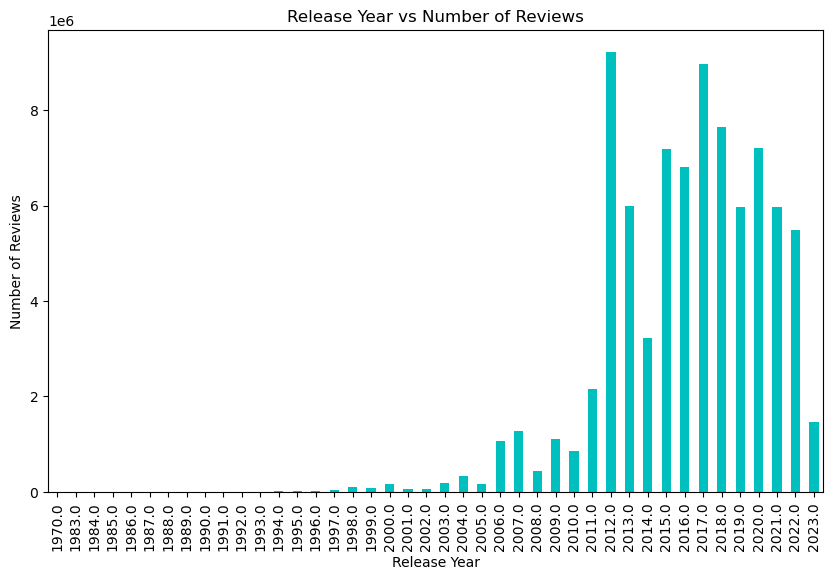

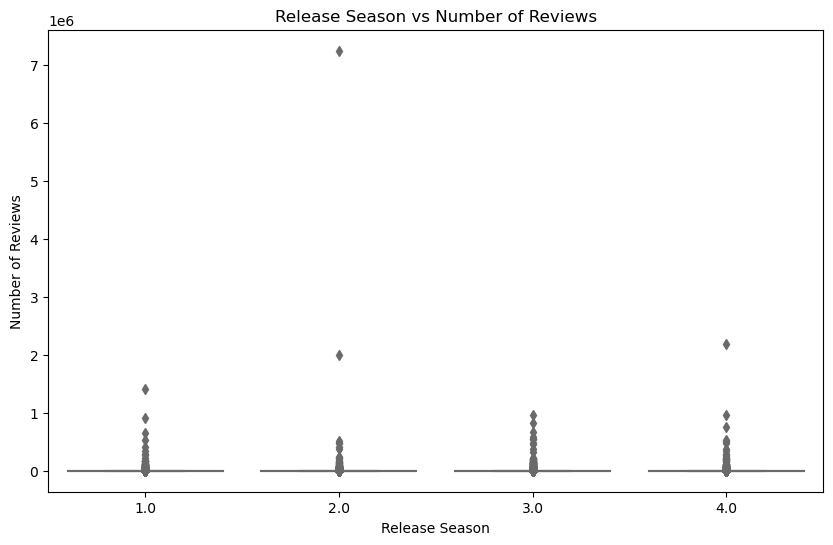

In [102]:
plt.figure(figsize=(10, 6))
df.groupby('Release Year')['Number of Reviews'].sum().plot(kind='bar', color='c')
plt.xlabel('Release Year')
plt.ylabel('Number of Reviews')
plt.title('Release Year vs Number of Reviews')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Release Season'], y=df['Number of Reviews'], palette='Set3')
plt.xlabel('Release Season')
plt.ylabel('Number of Reviews')
plt.title('Release Season vs Number of Reviews')
plt.show()

The analysis of game release years reveals interesting patterns in terms of the number of reviews received. Older games, released prior to 2005, demonstrate low popularity and a significantly lower number of reviews. Similarly, games released between 2005 and 2010 exhibit a relatively modest review count.

However, there is a noticeable shift in 2011, where games experience a significant increase in the number of reviews. This surge is further amplified in 2012, setting a new standard for yearly reviews. It's worth noting that this spike in 2012 could be attributed to the release of the highly successful game Counter-Strike, which launched in August of that year and continues to hold the highest reviews and rank first in sales (despite being a free-to-play game).

Following the peak in 2012, there is a decline in reviews in the subsequent years, although still maintaining relatively high numbers. The period from 2012 to 2013 marks a substantial drop in reviews, but the count remains considerable. From 2014 to 2017, there is a resurgence in reviews, followed by a gradual decline that still maintains significant figures.

These observations indicate that there are certain years, such as 2012, where games experienced a notable increase in reviews, potentially influenced by the release of major titles. Furthermore, despite fluctuations, there is an overall trend of maintaining a significant number of reviews in subsequent years.

It's important to consider various factors that may contribute to these trends, including the release of influential games, advancements in gaming technology, and changing consumer preferences.

When examining the relationship between the release season and the success of games, we can observe distinct patterns. Games released in the fall season showcase the highest level of success, followed closely by games released in both winter and spring. On the other hand, games released during the summer season tend to have a lower rating, with a few exceptions in specific years where certain well-received titles stand out.

The fall season appears to be particularly favorable for game releases, possibly due to the holiday season and increased consumer interest during that period. Winter and spring releases also show promising results, indicating that they are not far behind in terms of popularity and reception.

However, games released during the summer season tend to face more challenges in terms of achieving reviews. It's important to note that there are a couple of years where specific well-received titles managed to defy this trend and perform exceptionally well during the summer. These exceptions could be attributed to the release of highly anticipated games that managed to capture significant attention and engagement from players.

Overall, these observations suggest that timing, as reflected in the release season, can influence the success and reception of games.

# MACHINE LEARNING

After thoroughly examining the available information, we have identified several key variables that we believe will play a crucial role in determining the success of video games. These variables will be integral to the assessment performed by our machine learning model.

Based on our analysis, we have observed that price is a significant factor influencing the number of reviews and interaction a game receives. Games that are free to play or have a low price range tend to attract a higher number of reviews compared to games with higher price points. This indicates that pricing strategy, including the inclusion of in-game purchases, can greatly impact the success of a game.

Additionally, we have noted the importance of considering the number of languages supported by a game. Certain languages or language groups may have a stronger influence on the number of reviews and overall reception of a game. Localization efforts in these key languages could potentially enhance user engagement and attract more reviews.

Furthermore, our analysis of genre trends highlights specific genres that have a higher chance of appearing in top-ranking games. These genres may hold valuable insights for predicting a game's success.

Finally, we have examined the relationship between release year and season with the number of reviews. We have observed that newer games, particularly those released after 2011, tend to receive higher review counts. Additionally, the season of release also appears to impact the success of a game, with fall releases being particularly successful.

Based on these findings, our machine learning model will consider these variables as important criteria for assessing the success of video games. By incorporating these factors into the model's analysis, we aim to generate accurate predictions and insights into future game success.

Choosing the right Machine Learning Algorithm:

In selecting the appropriate algorithm for our analysis, several considerations were taken into account to ensure an accurate and comprehensive model. The following factors guided our decision:

Ensemble Learning: Given that the features we wanted to incorporate in our model (price, genres, release year, release season, languages, number of languages, features, developers, publishers) are not necessarily interconnected, we opted for an ensemble learning approach. This led us to choose RandomForestClassifier, which combines multiple decision trees to improve prediction accuracy.

Feature Importance: We were interested in determining the most influential features for predicting game success. Therefore, we sought an algorithm that provides a feature importance measure. RandomForestClassifier was a suitable choice as it assigns importance scores to each feature based on its contribution to the model's predictions.

Handling Categorical and Numeric Data: Since our dataset contains a mix of categorical and numeric data, it was crucial to select an algorithm capable of handling both types effectively. RandomForestClassifier can accommodate this diverse data representation without extensive preprocessing.

Efficiency on Large Datasets: With a dataset comprising over 50,000 entries and a significant number of features (including lists of genres, features, and languages), we needed an algorithm that could efficiently handle large-scale data. RandomForestClassifier is known for its efficiency in analyzing substantial datasets, making it a suitable choice for our analysis.

Binary Classification for Success Prediction: Our goal was to predict game success based on a provided threshold for the number of reviews. RandomForestClassifier is well-suited for binary classification tasks, aligning perfectly with our objective.

By considering these factors, RandomForestClassifier emerged as a well-rounded choice for our machine learning model. It addresses the complexities of our dataset, provides feature importance information, handles categorical and numeric data effectively, performs efficiently on large datasets, and supports binary classification for success prediction.

/var/folders/lx/jbht_9_x1x930wp7dwmw11sm0000gn/T/ipykernel_3732/1024323076.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Success'] = df['Number of Reviews'].apply(lambda x: 1 if x > threshold else 0)


Accuracy: 0.8063437373327929
ROC-AUC: 0.7022203232711693


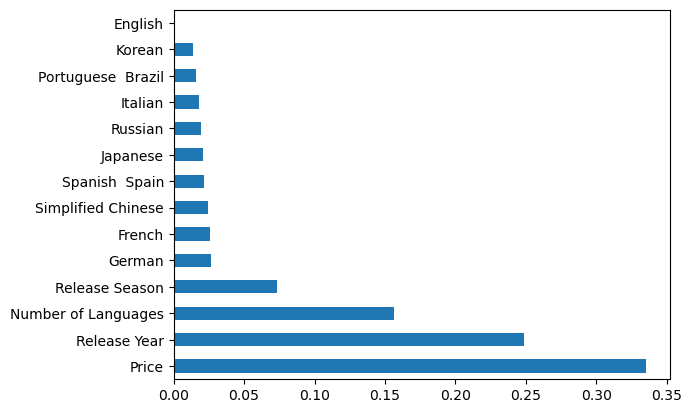

In [106]:
df = pd.read_csv('modified_gamedata.csv')

def process_features(df, column):
    df.loc[:, column] = df[column].apply(lambda x: re.sub(r"[^a-zA-Z0-9, ]", "", x))

    df.loc[:, column] = df[column].str.split(', ')

    df_dummy = pd.get_dummies(df[column].apply(pd.Series).stack()).groupby(level=0).sum()
    
    df = pd.concat([df, df_dummy], axis=1)
    df = df.drop([column], axis=1)
    
    return df, df_dummy.columns

for column in ['Genres', 'Num of Players', 'Features', 'Developers', 'Publishers', 'Languages']:
    df, new_features = process_features(df, column)


df = df.fillna(df.mean(numeric_only=True))

threshold = df['Number of Reviews'].quantile(0.75)

df['Success'] = df['Number of Reviews'].apply(lambda x: 1 if x > threshold else 0)

common_features = df[new_features].sum().nlargest(10).index

features = list(common_features) + ['Price','Number of Languages', 'Release Year', 'Release Season']
target = 'Success'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, predictions))
print('ROC-AUC:', roc_auc_score(y_test, predictions))

importances = model.feature_importances_
feature_importances = pd.Series(importances, index=features)
feature_importances.nlargest(15).plot(kind='barh')
plt.show()

After running the model, we achieved an accuracy of 80.63% and an ROC-AUC of 70.2%. The disparities between our assumptions and the final results are quite intriguing.

Contrary to our expectations, none of the game genres appeared to be significant in predicting a game's success. This finding was surprising, as we initially believed that certain genres would have a notable impact.

Additionally, we were intrigued to discover that the German and French languages had relatively high importance in the prediction, which we hadn't anticipated. While we were aware of other languages' involvement in the gaming industry, the prominence of German and French was unexpected.

Furthermore, the significant importance assigned to the release year aligns with the observations from the graph. Initially, we did not consider the release date, especially the year, as a critical factor. However, the model's emphasis on the release year highlights its importance in predicting a game's success.

# Summary and Conclusions:

The goal of our project was to explore the factors influencing the success of video games and build a machine learning model to predict their success. We scrapped, cleaned and analyzed a dataset containing information on various features of video games, such as genres, price, release year, release season, languages, and more.

Throughout our analysis, we made several interesting observations. We initially hypothesized that certain genres would have a significant impact on a game's success. However, after running our machine learning model, we found that no specific genre stood out as a strong predictor.

We discovered that the price of a game was the most important factor in predicting its success. Games with a low price or free-to-play model tended to receive higher numbers of reviews and interaction, suggesting that the pricing strategy has a significant impact on a game's popularity.

Additionally, our model highlighted the release year and release season as important factors in determining a game's success. Games released in more recent years, tended to have higher numbers of reviews. Furthermore, games released in the fall season exhibited the highest level of success, followed closely by winter and spring releases.

Another noteworthy observation was the very high importance of the number of languages. Specifically, games localized in German and French garnered a significant number of reviews, emphasizing the influence of language localization on game popularity. This finding highlighted the importance of catering to specific language markets for developers seeking wider reach and engagement.

Using this knowledge, we built a machine learning model, specifically the RandomForestClassifier algorithm, to predict game success. The model achieved an accuracy of 80.63% and an ROC-AUC of 70.2%. It effectively handled both categorical and numerical data and provided valuable insights into the relative importance of different features.

In conclusion, our project demonstrated that predicting video game success is a complex task with various factors at play. While genres may not be the primary driver of success, the price of the game emerged as the most important factor. Additionally, the release year, release season, and number of languages were found to significantly influence a game's performance. These findings provide valuable insights for developers and stakeholders in the gaming industry, enabling them to make informed decisions regarding pricing strategies, release timing, and language localization to enhance the success of their games.